# Inverse design of a digital power splitter

Reducing the size of silicon photonic devices while preserving performance is crucial for compact applications like on-chip optical interconnects, prompting interest in inverse design techniques for ultracompact and high-performance devices. 

In this notebook, we demonstrate the inverse design of a digital power splitter, utilizing photonic crystal-like structures composed of cylindrical holes. The design parameters are the permittivity value of each cylinder, which is controlled between that of air and silicon. The method consists of three stages: 

 - First, continuously optimizing cylinder permittivities through adjoint sensitivity analysis to achieve an analog pattern.
 - Second, employing linear-biasing to push this analog pattern towards a quasi-digital state. 
 - Finally, applying a fabrication-constrained brute-force quantization to convert the quasi-digital pattern into a fully digital (ternary) design.

This staged approach minimizes performance degradation during digitization while addressing computational and fabrication limitations. The notebook is largely based on the study `Kaiyuan Wang, Xinshu Ren, Weijie Chang, Longhui Lu, Deming Liu, and Minming Zhang, "Inverse design of digital nanophotonic devices using the adjoint method," Photon. Res. 8, 528-533 (2020)` [DOI: 10.1364/PRJ.383887](https://doi.org/10.1364/PRJ.383887).

<img src="img/digital_splitter_invdes.png" width=400 alt="Schematic of the inverse designed digital power splitter">

If you are unfamiliar with inverse design, we also recommend our [intro to inverse design tutorials](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and our [primer on automatic differentiation with tidy3d](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/). For another example of power splitter optimization in Tidy3D, see [this example](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd10YBranchLevelSet/).

In [1]:
import autograd.numpy as anp
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
from autograd import value_and_grad

## Base Simulation Setup

First we set up basic simulation parameters. The wavelength of interest is 1530 to 1570 nm.

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.53, 1.57, 5)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

Next we define relevant geometry parameters. The design is based on 220 nm silicon on oxide. The air holes are partially etched with an etching depth of 140 nm. Single-mode waveguides with 500 nm width are used. The design region is a square of size length 2.6 μm. Each pixel has a size of 130 nm, which makes the design region a 20 by 20 array. 

Three materials are involved in this design, namely silicon, oxide, and air. 

In [3]:
l = 2.6  # design region side length
p = 0.13  # pixel size
n = int(l / p)  # number of pixels in each direction

h_si = 0.22  # silicon layer thickness
w = 0.5  # waveguide width

r = 0.045  # radius of the hole
h_air = 0.14  # etching depth of the hole

d = 1  # distance between the two waveguides

eps_si = 12  # permittivity of silicon
eps_air = 1  # permittivity of air
eps_sio2 = 1.44**2  # permittivity of oxide

# define mediums
si = td.Medium(permittivity=eps_si)
air = td.Medium(permittivity=eps_air)
sio2 = td.Medium(permittivity=eps_sio2)

The static structures of the design can be refined first. It consists of three waveguides and a square design region. Later in the notebook we will enforce symmetry in the y direction so in principle the bottom output waveguide is not needed. For the sake of more intuitive visualization, we will define it here.

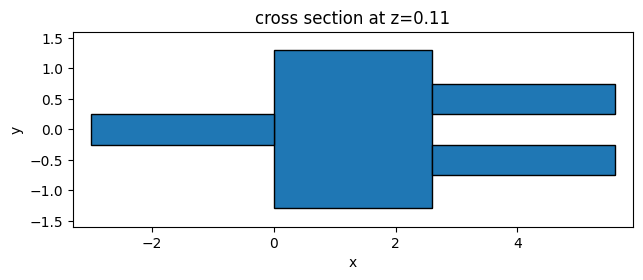

In [4]:
# define the static design region geometry
design_region = td.Box.from_bounds(rmin=(0, -l / 2, 0), rmax=(l, l / 2, h_si))
wg_length = 3  # length of the waveguides

# define the input waveguide geometry
wg_in = td.Box(center=(-wg_length / 2, 0, h_si / 2), size=(wg_length, w, h_si))

# define the top output waveguide geometry
wg_out_1 = td.Box(center=(l + wg_length / 2, d / 2, h_si / 2), size=(wg_length, w, h_si))

# define the bottom output waveguide geometry
wg_out_2 = td.Box(center=(l + wg_length / 2, -d / 2, h_si / 2), size=(wg_length, w, h_si))

# define the entire static waveguide structure
base_structure = td.Structure(geometry=design_region + wg_in + wg_out_1 + wg_out_2, medium=si)

inf_eff = 1e2  # effective infinity

# define the box structure
box = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)),
    medium=sio2,
)

# plot the static structure for visualization
base_structure.plot(z=h_si / 2)
plt.show()

We create a [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html) to excite the fundamental mode at the input waveguide and a [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) to measure the transmission power of the mode at one of the output waveguides. Due to symmetry, the power on both output waveguides is identical. 

In [5]:
# add a mode source as excitation
mode_spec = td.ModeSpec(num_modes=1, target_neff=np.sqrt(eps_si))
mode_source = td.ModeSource(
    center=(-lda0 / 2, 0, h_si / 2),
    size=(0, 1.9 * w, 6 * h_si),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# add a mode monitor to measure transmission at the output waveguide
mode_monitor = td.ModeMonitor(
    center=(l + lda0 / 2, d / 2, h_si / 2),
    size=mode_source.size,
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

In this design optimization, the design parameters are an array of 200 permittivity values between 1 (air) and 12 (silicon). Here we create a function that takes the design parameter array and returns a list of cylinders with the appropriate shape and permittivity. 

In [6]:
def make_holes(design_params):
    """
    Create a list of cylindrical holes with appropriate permittivity values based on design_params.

    Parameters
    ----------
    design_params : np.ndarray
        1D array of design parameter values.

    Returns
    -------
    holes : list
        A list of td.Structure objects corresponding to the holes.
    """
    eps = design_params.reshape((n, int(n / 2)))

    holes = [
        td.Structure(
            geometry=td.Cylinder(
                center=(i * p + p / 2, j * p + p / 2, h_si - h_air / 2),
                radius=r,
                length=h_air,
                axis=2,
            ),
            medium=td.Medium(permittivity=eps[i, j]),
        )
        for i in range(n)
        for j in range(int(n / 2))
    ]

    return holes

Subsequently, we create a function that takes the design parameter array and creates a [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) object. Here we use an automatic nonuniform grid with a grid size of 20 steps per material wavelength as a demonstration. Since the holes are relatively small, even though subpixel averaging is very helpful, to get the most accurate result a higher resolution is recommended.

In [7]:
run_time = 1e-12  # simulation run time
buffer = 0.6 * lda0  # buffer spacing slightly larger than half a wavelength to avoid warning


def make_sim(design_params):
    """
    Create a simulation based on design_params.

    Parameters
    ----------
    design_params : np.ndarray
        1D array of design parameter values.

    Returns
    -------
    sim : td.Simulation
        A Tidy3D simulation
    """

    # create holes
    holes = make_holes(design_params)

    # construct simulation
    sim = td.Simulation(
        center=(l / 2, 0, 0),
        size=(l + 2 * buffer, l + 2 * buffer, h_si + 2 * buffer),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
        structures=[base_structure, box] + holes,
        sources=[mode_source],
        monitors=[mode_monitor],
        run_time=run_time,
        symmetry=(0, -1, 0),
    )

    return sim

To visualize and validate the setup, we can create a random simulation.

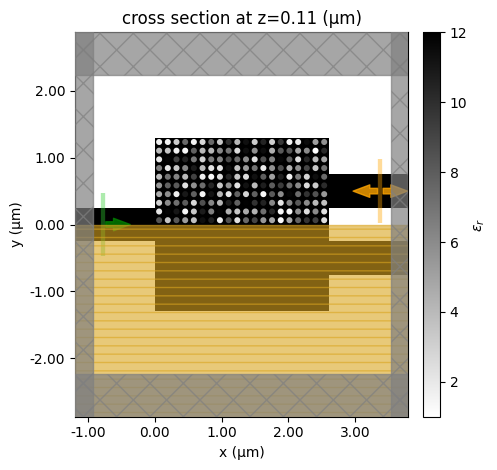

In [8]:
sim = make_sim(design_params=np.random.uniform(eps_air, eps_si, int(n * n / 2)))

sim.plot_eps(z=h_si / 2)
plt.show()

Most importantly, we create a function that takes the design parameters and compute the figure of merit, which is simply the averaged transmission power of the fundamental mode at the output waveguide.

In [9]:
def fom(design_params):
    """
    Calculate the figure of merit based on the design parameters.
    """

    sim = make_sim(design_params)
    sim_data = web.run(simulation=sim, task_name="inv_des", local_gradient=False, verbose=False)
    amp = sim_data["mode"].amps.sel(mode_index=0, direction="+").values

    return anp.mean(anp.abs(amp) ** 2)

## Optimization Stage 1

Now we are ready to start the optimization process. We pick the initial condition to be uniform. That is, all cylinder holes start with a permittivity value of 6.5, the average between silicon and air. 


In [10]:
design_params0 = 0.5 * (eps_si + eps_air) * np.ones(int(n * n / 2))  # initial design parameters

grad_fn = value_and_grad(fom)

In this stage of the optimization, we will update the design parameters continuously via 

$$
\varepsilon_r^{\text{new}}(p) = \varepsilon_r^{\text{old}}(p) + \Delta \cdot \delta\varepsilon_r(p),
$$

where $p$ denotes the position of the cylinder, $\delta\varepsilon(p)$  is the gradient, and $\Delta$ is a variable to control the speed. Here $\Delta$ is chosen to be $\Delta = 1 / \max\{\delta\varepsilon_r(p)\}$.

We will only run 25 iterations in this stage for demonstration purposes. Running more iterations can potentially be beneficial. Every 5 iterations, we will show the permittivity distribution to help visualize the progression of the inverse design.

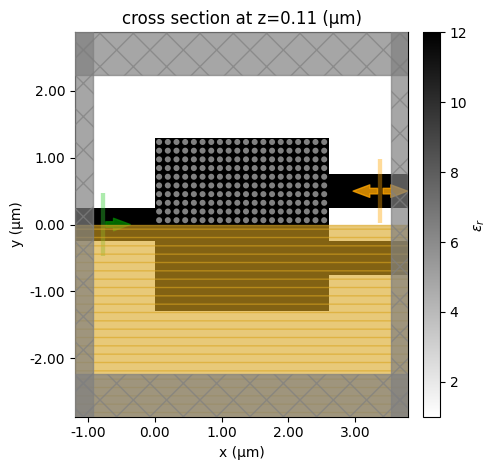

Iteration: 1
FOM = 1.111e-01
---------------
Iteration: 2
FOM = 1.572e-01
---------------
Iteration: 3
FOM = 2.031e-01
---------------
Iteration: 4
FOM = 2.454e-01
---------------
Iteration: 5
FOM = 2.819e-01
---------------


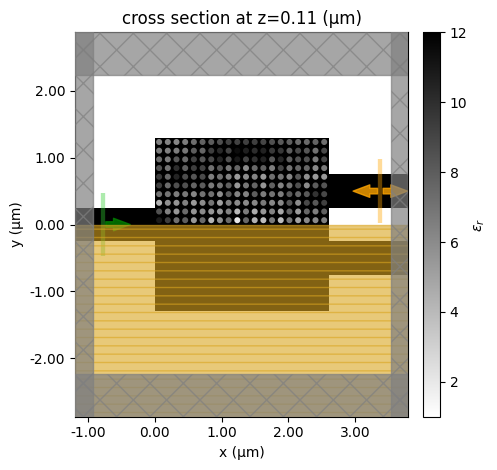

Iteration: 6
FOM = 3.126e-01
---------------
Iteration: 7
FOM = 3.393e-01
---------------
Iteration: 8
FOM = 3.619e-01
---------------
Iteration: 9
FOM = 3.804e-01
---------------
Iteration: 10
FOM = 3.958e-01
---------------


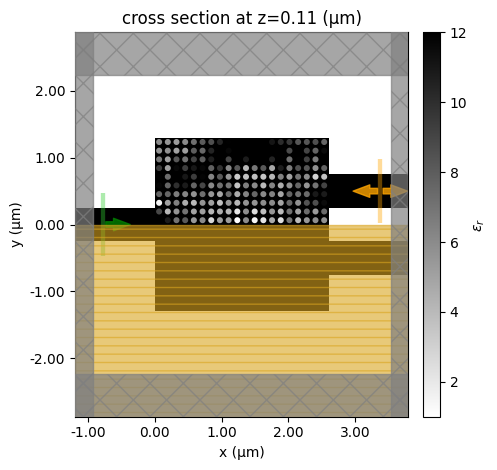

Iteration: 11
FOM = 4.084e-01
---------------
Iteration: 12
FOM = 4.174e-01
---------------
Iteration: 13
FOM = 4.250e-01
---------------
Iteration: 14
FOM = 4.318e-01
---------------
Iteration: 15
FOM = 4.377e-01
---------------


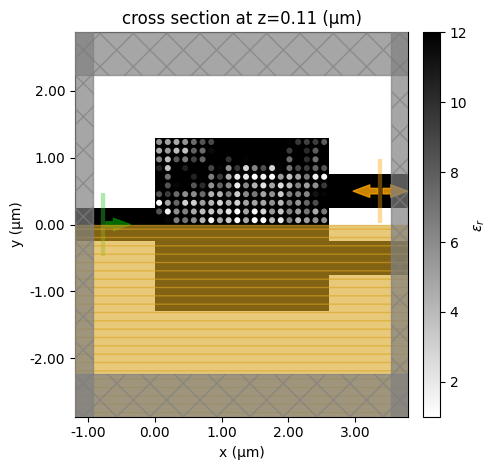

Iteration: 16
FOM = 4.428e-01
---------------
Iteration: 17
FOM = 4.463e-01
---------------
Iteration: 18
FOM = 4.495e-01
---------------
Iteration: 19
FOM = 4.521e-01
---------------
Iteration: 20
FOM = 4.546e-01
---------------


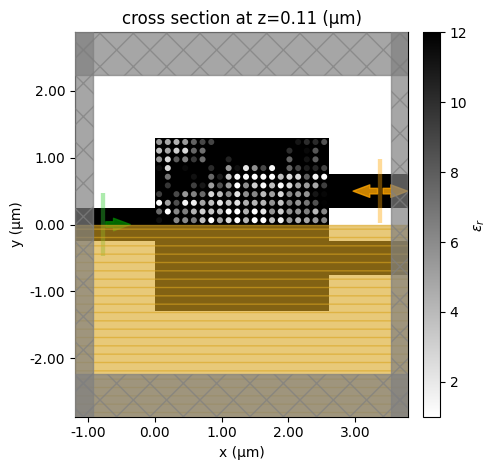

Iteration: 21
FOM = 4.567e-01
---------------
Iteration: 22
FOM = 4.587e-01
---------------
Iteration: 23
FOM = 4.603e-01
---------------
Iteration: 24
FOM = 4.616e-01
---------------
Iteration: 25
FOM = 4.627e-01
---------------


In [11]:
n_iter = 25  # number of iterations

# initialize the optimization loop
design_params = design_params0
fom_history = []
params_history = []

for i in range(n_iter):
    # show a permittivity plot every 5 iterations
    if i % 5 == 0:
        make_sim(design_params).plot_eps(z=h_si / 2)
        plt.show()

    # calculate gradient
    val, grad = grad_fn(design_params)

    print(f"Iteration: {i + 1}")
    print(f"FOM = {val:.3e}")
    print("---------------")
    fom_history.append(val)
    params_history.append(design_params)

    # update design parameters
    delta = 1 / np.max(grad)
    design_params = design_params + delta * grad
    anp.clip(design_params, eps_air, eps_si, out=design_params)

We can see that the figure of merit has increased significantly during the optimization. It's already quite close to the upper limit of 0.5.

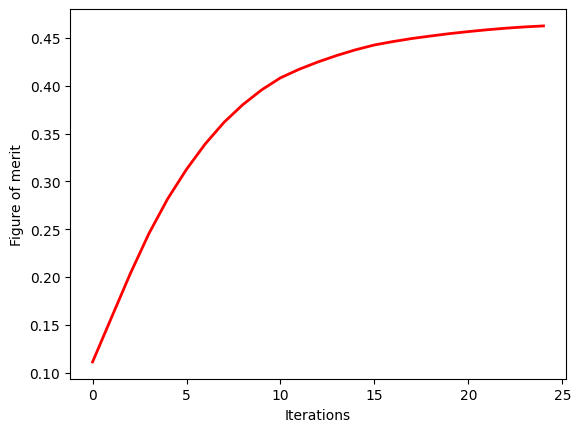

In [12]:
plt.plot(fom_history, c="red", linewidth=2)
plt.xlabel("Iterations")
plt.ylabel("Figure of merit")
plt.show()

## Optimization Stage 2

Next we move on to the second stage of the optimization. In this stage, we want to encourage binarization. That is, pushing the design parameters to either the permittivity of air or silicon. This is done by applying an additional bias in the design parameter update:

$$
\varepsilon_r^{\text{biased}}(p) = (1 + m)\cdot\left[\varepsilon_r^{\text{new}}(p)-6.5\right] + 6.5,
$$

where $m$ is a hyperparameter that controls the strength of the biasing. We set it to 0.05 in this case. This biasing will gradually encourage the permittivity value to become closer to 1 if it's below 6.5 and to 12 if it's above.

During the optimization, we can calculate the mean square error to quantify binarization:

$$
\sigma = \frac{1}{M}\sum_{n=1}^{M}\rho_n,\quad
\rho_n = 
\begin{cases}
|\varepsilon_r(n)-1|^2, & 1 \leq \varepsilon_r(n) < 6.5\\[6pt]
|\varepsilon_r(n)-12|^2, & 6.5 \leq \varepsilon_r(n) \leq 12
\end{cases}
$$

As the iterations progress, the mean square error should decrease. Ideally at the same time the figure of merit does not decrease noticeably at the same time.

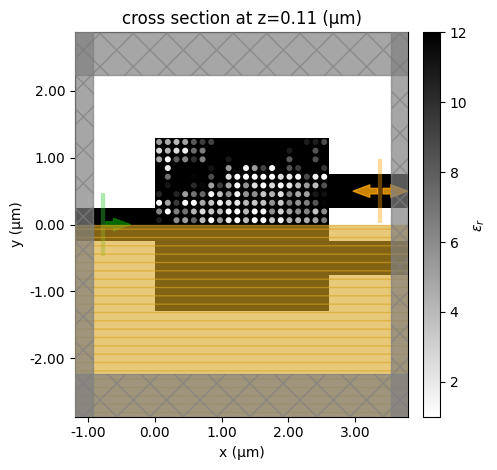

Iteration: 1
FOM = 4.636e-01
MSE = 6.901e+00
Iteration: 2
FOM = 4.649e-01
MSE = 6.392e+00
Iteration: 3
FOM = 4.661e-01
MSE = 6.008e+00
Iteration: 4
FOM = 4.671e-01
MSE = 5.621e+00
Iteration: 5
FOM = 4.679e-01
MSE = 5.298e+00


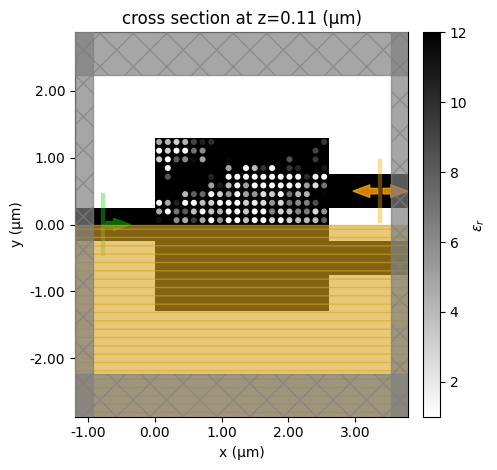

Iteration: 6
FOM = 4.685e-01
MSE = 4.994e+00
Iteration: 7
FOM = 4.692e-01
MSE = 4.722e+00
Iteration: 8
FOM = 4.698e-01
MSE = 4.441e+00
Iteration: 9
FOM = 4.704e-01
MSE = 4.173e+00
Iteration: 10
FOM = 4.708e-01
MSE = 3.909e+00


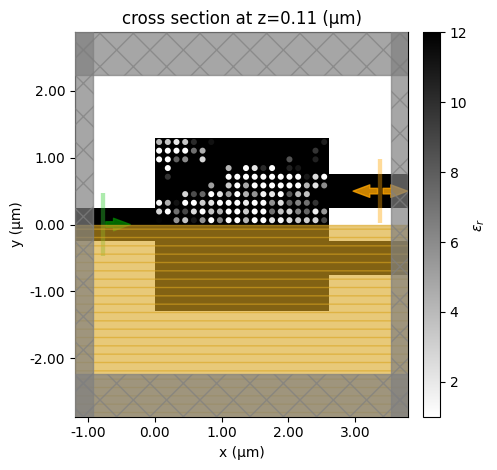

Iteration: 11
FOM = 4.712e-01
MSE = 3.700e+00
Iteration: 12
FOM = 4.715e-01
MSE = 3.469e+00
Iteration: 13
FOM = 4.718e-01
MSE = 3.309e+00
Iteration: 14
FOM = 4.719e-01
MSE = 3.119e+00
Iteration: 15
FOM = 4.721e-01
MSE = 3.016e+00


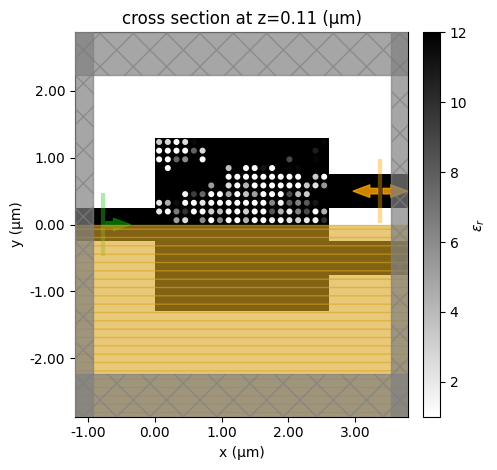

Iteration: 16
FOM = 4.720e-01
MSE = 2.855e+00
Iteration: 17
FOM = 4.715e-01
MSE = 2.825e+00
Iteration: 18
FOM = 4.714e-01
MSE = 2.635e+00
Iteration: 19
FOM = 4.706e-01
MSE = 2.644e+00
Iteration: 20
FOM = 4.710e-01
MSE = 2.438e+00


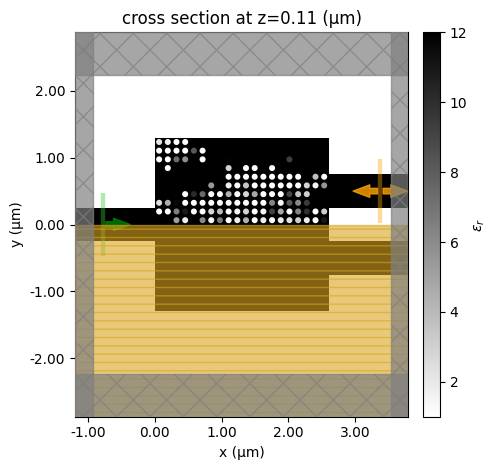

Iteration: 21
FOM = 4.713e-01
MSE = 2.454e+00
Iteration: 22
FOM = 4.711e-01
MSE = 2.298e+00
Iteration: 23
FOM = 4.719e-01
MSE = 2.292e+00
Iteration: 24
FOM = 4.713e-01
MSE = 2.203e+00
Iteration: 25
FOM = 4.720e-01
MSE = 2.186e+00


In [13]:
n_iter = 25  # number of iterations

mse_history = []

for i in range(n_iter):
    if i % 5 == 0:
        make_sim(design_params).plot_eps(z=h_si / 2)
        plt.show()

    val, grad = grad_fn(design_params)

    # calculate the mean square error for binarization
    mse = np.sum(
        np.where(
            design_params < (eps_si + eps_air) / 2,
            (design_params - eps_air) ** 2,
            (design_params - eps_si) ** 2,
        )
    ) / len(design_params)

    print(f"Iteration: {i + 1}")
    print(f"FOM = {val:.3e}")
    print(f"MSE = {mse:.3e}")

    fom_history.append(val)
    params_history.append(design_params)
    mse_history.append(mse)

    delta = 1 / np.max(grad)
    design_params = design_params + delta * grad

    # apply binarization bias
    m = 0.05
    design_params = (1 + m) * (design_params - (eps_si + eps_air) / 2) + (eps_si + eps_air) / 2

    anp.clip(design_params, eps_air, eps_si, out=design_params)

In [14]:
params_history.append(design_params)

Visualize the decrease of the mean square error.

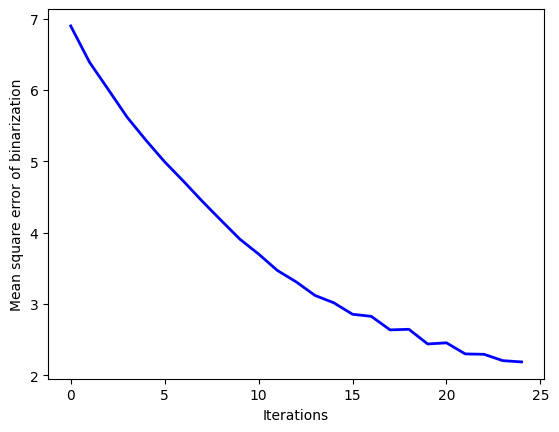

In [15]:
plt.plot(mse_history, c="blue", linewidth=2)
plt.xlabel("Iterations")
plt.ylabel("Mean square error of binarization")
plt.show()

At the same time, we plot the entire figure of merit history to see if it degrades during the digitization process. In this case, no degradation is observed. 

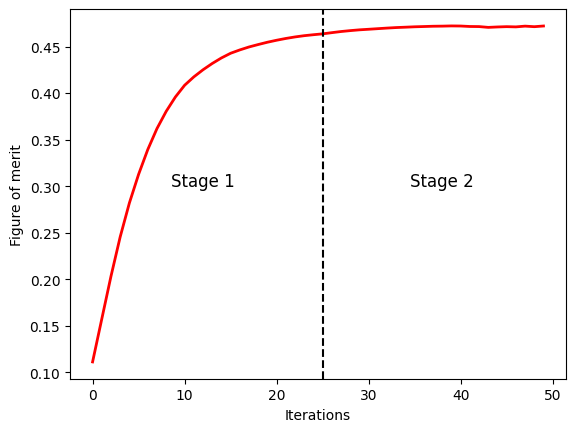

In [16]:
plt.plot(fom_history, c="red", linewidth=2)
plt.xlabel("Iterations")
plt.ylabel("Figure of merit")
plt.axvline(x=25, color="black", linestyle="--")
plt.text(12, 0.3, "Stage 1", fontsize=12, horizontalalignment="center")
plt.text(38, 0.3, "Stage 2", fontsize=12, horizontalalignment="center")
plt.show()

## Optimization Stage 3

In the last stage of the optimization, we will fully digitize the cylinders. Here we apply a ternary digitization, where if the permittivity of a cylinder is above 9.25, it will become a silicon cylinder. If the permittivity is below 3.75, it will become an air cylinder. If the permittivity is between 3.75 and 9.25, we will replace it with an air cylinder with a smaller radius. This way the final design is fabricable. 

For the cylinders with a reduced radius, we need to determine the optimal radius value. This can be done by a simple parameter sweep.

In [17]:
def digitize_holes(design_params, r_replace):
    """
    Create a list of cylindrical holes with appropriate radii based on design_params.

    Parameters
    ----------
    design_params : np.ndarray
        1D array of design parameter values.
    r_replace : float
        Reduced radius used for intermediate holes.

    Returns
    -------
    holes : list
        A list of td.Structure objects corresponding to the holes.
    """

    # digitize the design parameters into three groups
    mask = np.digitize(design_params, [3.75, 9.25]).reshape((n, n // 2))

    # indices where mask == 0 and mask == 1
    coords_0 = np.argwhere(mask == 0)  # these get radius = r
    coords_1 = np.argwhere(mask == 1)  # these get radius = r_replace

    holes = []

    # append holes for mask == 0
    for i, j in coords_0:
        holes.append(
            td.Structure(
                geometry=td.Cylinder(
                    center=(i * p + p / 2, j * p + p / 2, h_si - h_air / 2),
                    radius=r,
                    length=h_air,
                    axis=2,
                ),
                medium=air,
            )
        )

    # append holes for mask == 1
    for i, j in coords_1:
        holes.append(
            td.Structure(
                geometry=td.Cylinder(
                    center=(i * p + p / 2, j * p + p / 2, h_si - h_air / 2),
                    radius=r_replace,
                    length=h_air,
                    axis=2,
                ),
                medium=air,
            )
        )

    return holes


def make_digitized_sim(design_params, r_replace):
    """
    Create a simulation based on design_params and reduced hole radius.
    """

    holes = digitize_holes(design_params, r_replace)

    # construct simulation
    sim = td.Simulation(
        center=(l / 2, 0, 0),
        size=(l + 2 * buffer, l + 2 * buffer, h_si + 2 * buffer),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
        structures=[base_structure, box] + holes,
        sources=[mode_source],
        monitors=[mode_monitor],
        run_time=run_time,
        symmetry=(0, -1, 0),
    )

    return sim

Create an arbitrary simulation to visualize. We can see that cylinders with a high permittivity disappear. Cylinders with a low permittivity become air holes. Cylinders with an intermedium permittivity become smaller holes. 

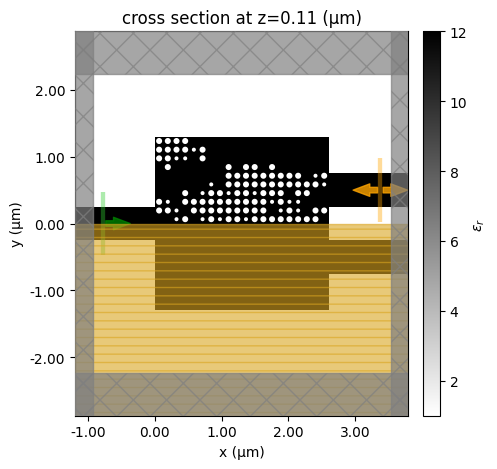

In [18]:
sim_digitized = make_digitized_sim(design_params, r_replace=0.03)
sim_digitized.plot_eps(z=h_si / 2)
plt.show()

Due to the limitation of fabrication, the smallest achievable hole radius is 30 nm. Therefore, we will look for the optimum hole radius between 30 nm and 45 nm. A parameter sweep is performed.

In [19]:
# list of reduced radii for parameter sweeping
r_replace_list = np.arange(0.03, 0.045, 0.002)

# perform parameter sweep
sims = {
    f"r_replace={1e3 * r_replace:.0f} nm": make_digitized_sim(design_params, r_replace=r_replace)
    for r_replace in r_replace_list
}
batch = web.Batch(simulations=sims, verbose=True)
batch_results = batch.run(path_dir="/data")

Output()

17:23:31 Eastern Daylight Time Started working on Batch containing 8 tasks.

17:23:38 Eastern Daylight Time Maximum FlexCredit cost: 0.207 for the whole     
                               batch.

                               Use 'Batch.real_cost()' to get the billed        
                               FlexCredit cost after the Batch has completed.

Output()

17:23:41 Eastern Daylight Time Batch complete.

Output()

After the sweep is finished, we can extract the averaged transmission and plot it as a function of reduced hole radius. It turns out that 30 nm is the optimal value as the loss increases with hole radius. 

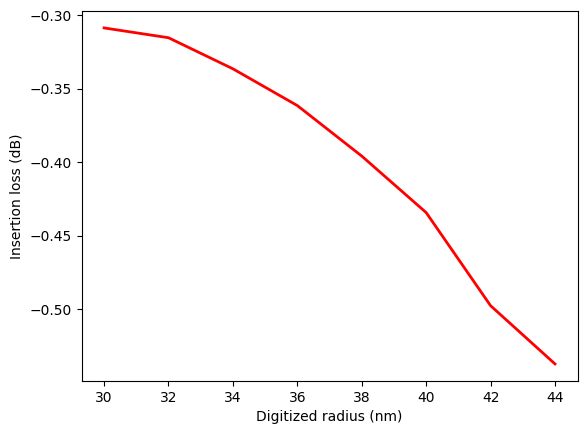

In [20]:
# extract the fundamental mode transmission power
T = np.array(
    [
        np.sum(
            np.abs(
                batch_results[f"r_replace={1e3 * r_replace:.0f} nm"]["mode"]
                .amps.sel(mode_index=0, direction="+")
                .values
            )
            ** 2
        )
        / len(ldas)
        for r_replace in r_replace_list
    ]
)

plt.plot(r_replace_list * 1e3, 10 * np.log10(2 * T), c="red", linewidth=2)
plt.xlabel("Digitized radius (nm)")
plt.ylabel("Insertion loss (dB)")
plt.show()

For better visualization, we will create a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) and add it to the simulation with the final optimized design. 

In [21]:
# create a simulation with the optimal reduced hole size
sim_opt = make_digitized_sim(design_params, r_replace=0.03)

# add a field monitor to visualize field distribution at z=t/2
field_monitor = td.FieldMonitor(
    center=(0, 0, h_si / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

# add the field monitor to the simulation
sim_opt = sim_opt.updated_copy(monitors=[field_monitor, mode_monitor])

Run the simulation again and plot the field distribution, which shows a nice power splitting.

17:23:56 Eastern Daylight Time Created task 'optimized' with task_id            
                               'fdve-44fe653c-6c6a-4c53-9fac-487f7a741c7f' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=368443;https://tidy3d.simulation.cloud/workbench?taskId=fdve-44fe653c-6c6a-4c53-9fac-487f7a741c7f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=596115;https://tidy3d.simulation.cloud/workbench?taskId=fdve-44fe653c-6c6a-4c53-9fac-487f7a741c7f\taskId]8;;\
                               ]8;id=368443;https://tidy3d.simulation.cloud/workbench?taskId=fdve-44fe653c-6c6a-4c53-9fac-487f7a741c7f\=]8;;\]8;id=709823;https://tidy3d.simulation.cloud/workbench?taskId=fdve-44fe653c-6c6a-4c53-9fac-487f7a741c7f\fdve]8;;\]8;id=368443;https://tidy3d.simulation.cloud/workbench?taskId=fdve-44fe653c-6c6a-4c53-9fac-487f7a741c7f\-44fe653c-6c6a-4c53-9fac-487f7a741c7f']8;;\.

                               Task folder: ]8;id=750484;https://tidy3d.simulation.cloud/folders/639eb096-a602-4b56-a502-cac1f18f9557\'default']8;;\.

Output()

17:23:58 Eastern Daylight Time Maximum FlexCredit cost: 0.025. Minimum cost     
                               depends on task execution details. Use           
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

17:23:59 Eastern Daylight Time status = success

Output()

17:24:00 Eastern Daylight Time loading simulation from simulation_data.hdf5

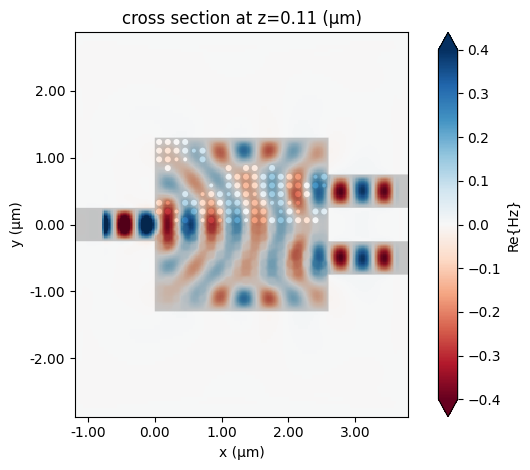

In [22]:
# run the optimized design again with the field monitor
sim_data_opt = web.run(sim_opt, "optimized")

# plot field distribution at the central wavelength
sim_data_opt.plot_field(
    field_monitor_name="field", field_name="Hz", val="real", vmin=-0.4, vmax=0.4
)
plt.show()

Finally plot the insertion loss spectrum. The optimized design has an insertion loss of ~0.3 dB, similar to the result reported in the [paper](https://doi.org/10.1364/PRJ.383887). Interestingly, the optimized design we obtained here appears to be quite different from that reported in the paper, even though the performance is similar. This showcases the power of inverse design. Since the design parameter space is very large, there likely exist multiple good designs.  

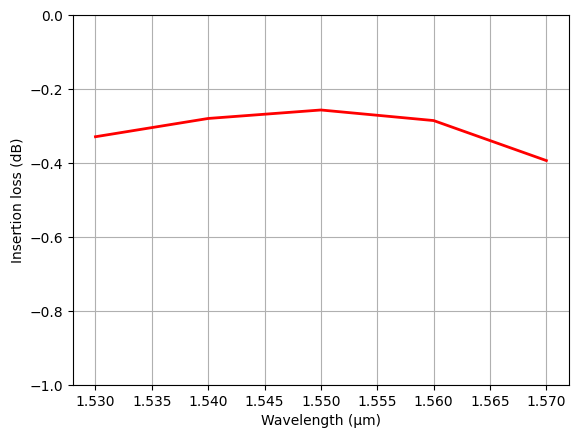

In [23]:
# calculate the insertion loss
il = 10 * np.log10(
    2 * np.abs(sim_data_opt["mode"].amps.sel(mode_index=0, direction="+").values) ** 2
)

plt.plot(ldas, il, c="red", linewidth=2)
plt.ylim(-1, 0)
plt.xlabel("Wavelength (μm)")
plt.ylabel("Insertion loss (dB)")
plt.grid()
plt.show()

## Final Remarks

In the actual fabrication, the hole radii are likely to deviate slightly from the design, which could lead to significant performance degradation of the device. In this optimization, we did not consider any fabrication robustness. In a subsequent [research paper](https://doi.org/10.1364/OE.544018), the authors incorporated fabrication robustness by including eroded holes and dilated holes in the figure of merit evaluation. The same strategy can be applied here to improve the design's immunity to fabrication variability.  